# Off-the-grid recovery of a simple image from noisy linear measurements

In [1]:
import time

import matplotlib as mpl
import matplotlib.cm as cm

from math import sqrt, log
from pycheeger import SimpleSet, compute_cheeger, plot_simple_functions
from tvsfw import SampledGaussianFilter, perform_sliding
from tvsfw.utils import *

np.random.seed(0)

### Defining the ground truth image

$$u_0=a_1\mathbf{1}_{E_1}+a_2\mathbf{1}_{E_2}+a_3\mathbf{1}_{E_3}$$

with $(a_1,a_2,a_3)=(1,-2,1.5)$ and $E_1,E_2,E_3$ defined below

In [2]:
points1 = np.array([[-0.6, 0.85], [-0.75, 0.65], [-0.65, 0.31], [-0.75, 0.0], [-0.5, -0.5],
                    [-0.15, 0.15], [0.1, 0.5], [-0.25, 0.85]]) + np.array([-0.1, -0.1])

points2 = 0.6 * np.array([[-0.2, 0.75], [-0.3, 0.5], [-0.2, 0.3], [0.25, 0.45], [0.3, 0.6], [0.25, 0.8]]) \
          + np.array([-0.45, 0.0])

points3 = np.array([[0.5, 0.25], [0.35, 0.1], [0.3, -0.1], [0.15, -0.3], [0.5, -0.5], [0.8, 0.0]]) \
          + np.array([0.0, -0.1])

weights = np.array([1.0, -2, 1.5])

In [3]:
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(weights) + 0.1), vmax=np.max(np.abs(weights) + 0.1))
cmap = cm.bwr
m = cm.ScalarMappable(norm=norm, cmap=cmap)

In [4]:
curve1 = interpolate_points(points1)
curve2 = interpolate_points(points2)
curve3 = interpolate_points(points3)

E1 = SimpleSet(curve1, max_tri_area=0.001)
E2 = SimpleSet(curve2, max_tri_area=0.001)
E3 = SimpleSet(curve3, max_tri_area=0.001)

u = SimpleFunction([WeightedIndicatorFunction(weights[0], E1),
                    WeightedIndicatorFunction(weights[1], E2),
                    WeightedIndicatorFunction(weights[2], E3)])

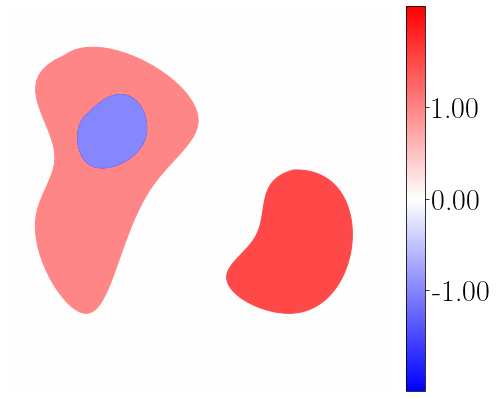

In [5]:
plot_simple_function(u, m)

### Computing observations

Observations are here computed by convoluting the ground truth image with a Gaussian kernel, and then sampling this convolution on a pixel grid. Some white noise is also added.

In [6]:
std = 0.05
std_noise = 1e-3
grid_size = 75
alpha = 0.25 * sqrt(2 * log(grid_size)) * std_noise

In [7]:
x_coarse, y_coarse = np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size)
X_coarse, Y_coarse = np.meshgrid(x_coarse, y_coarse)
grid = np.stack([X_coarse, Y_coarse], axis=2)

phi = SampledGaussianFilter(grid, std)

y = u.compute_obs(phi, version=0)

noise = np.random.normal(0, std_noise, y.shape)
noisy_y = y + noise

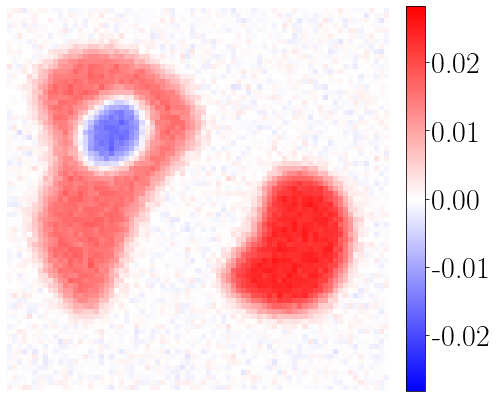

In [8]:
plot_obs(noisy_y, cmap, v_abs_max=np.max(1.1 * np.abs(noisy_y)))

## First iteration

### Cheeger step

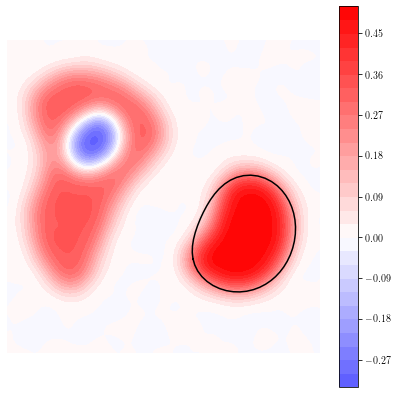

In [9]:
u_hat = SimpleFunction([])

new_y = u_hat.compute_obs(phi, version=0)
residual = noisy_y - new_y
eta = phi.apply_adjoint(noisy_y - new_y)

E, obj_tab, grad_norm_tab = compute_cheeger(eta,
                                            max_tri_area_fm=1e-3, max_iter_fm=10000,
                                            num_boundary_vertices_ld=50, max_tri_area_ld=1e-2, 
                                            step_size_ld=1e-2, max_iter_ld=200, convergence_tol_ld=1e-6, 
                                            num_iter_resampling_ld=60, plot_results_ld=True)



u_hat.extend_support(E)
u_hat.fit_weights(noisy_y, phi, alpha)

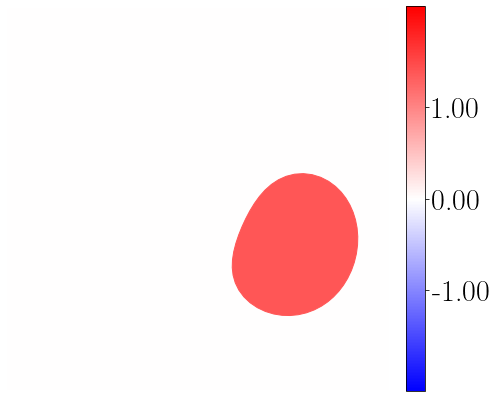

In [10]:
plot_simple_function(u_hat, m)

### Sliding step

In [11]:
u_hat, obj_tab, grad_norm_tab = perform_sliding(u_hat, noisy_y, phi, alpha, 0.5, 200, None, None,
                                                1e-8, 60, 50, 0.004)

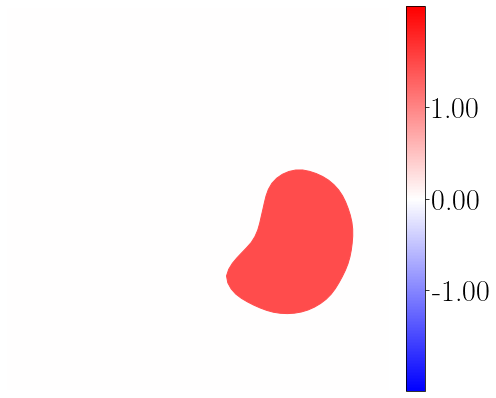

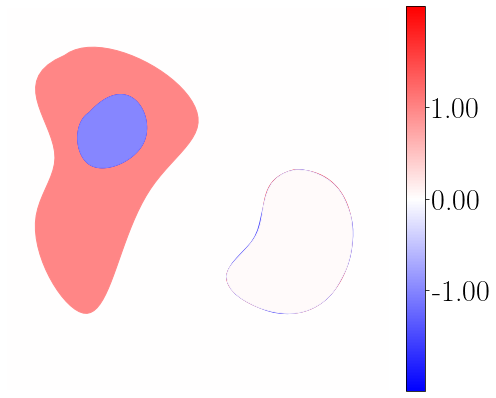

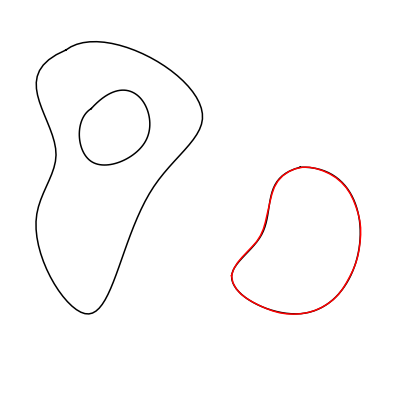

In [12]:
plot_simple_function(u_hat, m)
plot_simple_function(simple_function_diff(u, u_hat), m)
plot_simple_functions(u, u_hat)

## Second iteration

### Cheeger step

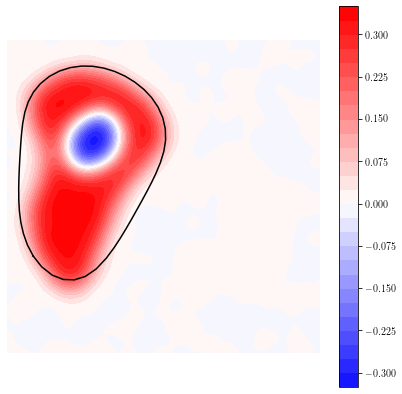

In [13]:
new_y = u_hat.compute_obs(phi, version=0)
residual = noisy_y - new_y
eta = phi.apply_adjoint(noisy_y - new_y)

E, obj_tab, grad_norm_tab = compute_cheeger(eta,
                                            max_tri_area_fm=1e-3, max_iter_fm=10000,
                                            num_boundary_vertices_ld=50, max_tri_area_ld=1e-2, 
                                            step_size_ld=1e-2, max_iter_ld=200, convergence_tol_ld=1e-6, 
                                            num_iter_resampling_ld=60, plot_results_ld=True)



u_hat.extend_support(E)
u_hat.fit_weights(noisy_y, phi, alpha)

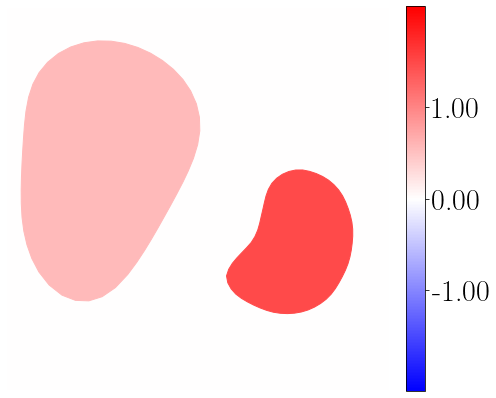

In [14]:
plot_simple_function(u_hat, m)

### Sliding step

In [15]:
u_hat, obj_tab, grad_norm_tab = perform_sliding(u_hat, noisy_y, phi, alpha, 0.5, 200, None, None,
                                                1e-8, 60, 50, 0.004)

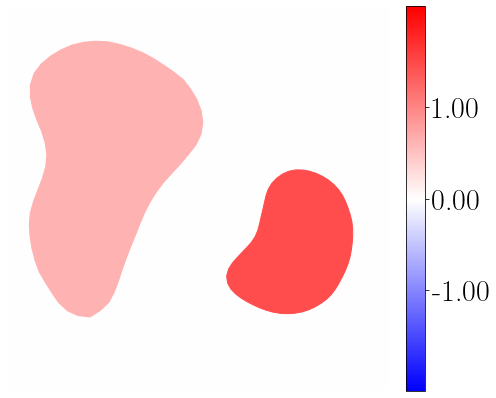

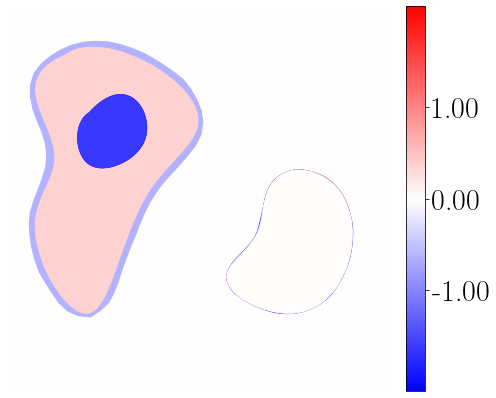

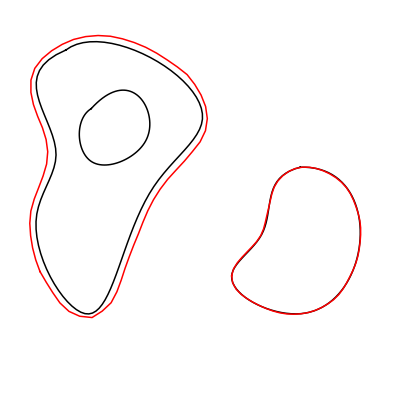

In [16]:
plot_simple_function(u_hat, m)
plot_simple_function(simple_function_diff(u, u_hat), m)
plot_simple_functions(u, u_hat)

## Third step

### Cheeger step

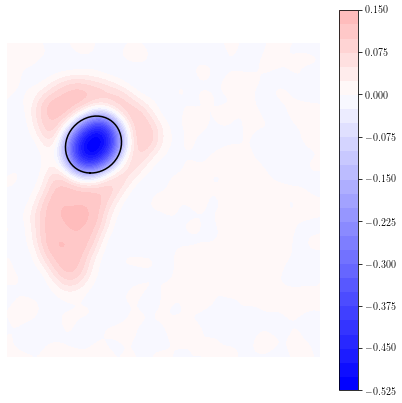

In [17]:
new_y = u_hat.compute_obs(phi, version=0)
residual = noisy_y - new_y
eta = phi.apply_adjoint(noisy_y - new_y)

E, obj_tab, grad_norm_tab = compute_cheeger(eta,
                                            max_tri_area_fm=1e-3, max_iter_fm=10000,
                                            num_boundary_vertices_ld=50, max_tri_area_ld=1e-2, 
                                            step_size_ld=1e-2, max_iter_ld=200, convergence_tol_ld=1e-6, 
                                            num_iter_resampling_ld=60, plot_results_ld=True)



u_hat.extend_support(E)
u_hat.fit_weights(noisy_y, phi, alpha)

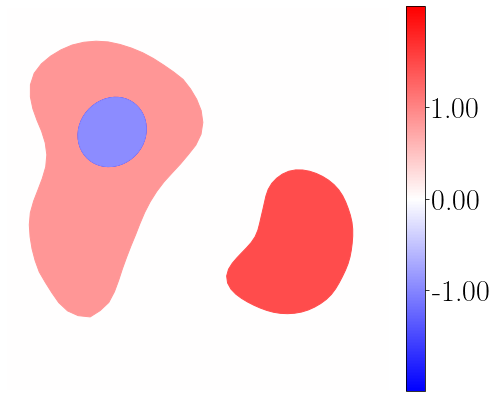

In [18]:
plot_simple_function(u_hat, m)

### Sliding step

In [19]:
u_hat, obj_tab, grad_norm_tab = perform_sliding(u_hat, noisy_y, phi, alpha, 0.5, 200, None, None,
                                                1e-8, 60, 50, 0.004)

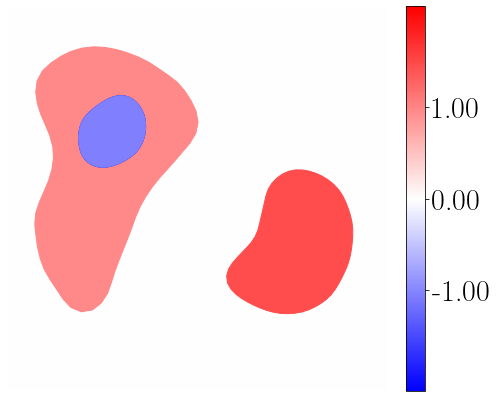

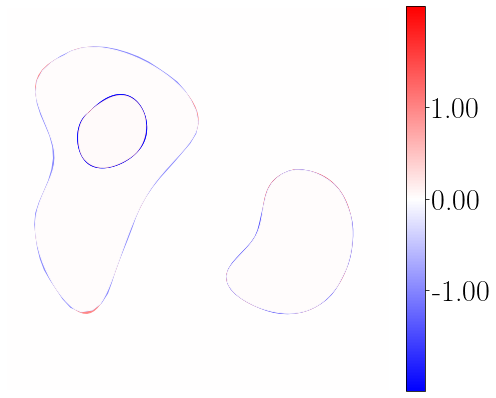

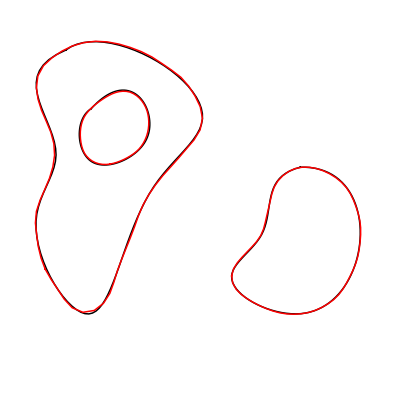

In [20]:
plot_simple_function(u_hat, m)
plot_simple_function(simple_function_diff(u, u_hat), m)
plot_simple_functions(u, u_hat)